# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to what subreddit it belongs to?_

Your method for acquiring the data will be scraping threads from at least two subreddits. 

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts which subreddit a given post belongs to.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [668]:
import requests
import pandas as pd
import numpy as np
import json
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction import stop_words
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt 

%matplotlib inline

In [4]:
url = "http://www.reddit.com/r/boardgames.json"

In [5]:
## 
res = requests.get(url, headers={'User-agent': 'GitUpstreamMaster'})
res.status_code

200

#### Use `res.json()` to convert the response into a dictionary format and set this to a variable. 

```python
data = res.json()
```

In [6]:
data= res.json()

In [7]:
data.keys()

dict_keys(['kind', 'data'])

In [8]:
data['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [9]:
len(data['data']['children'])

27

In [10]:
data['data']['children'][0]

{'kind': 't3',
 'data': {'approved_at_utc': None,
  'subreddit': 'boardgames',
  'selftext': 'Welcome to the monthly [/r/boardgames](https://www.reddit.com/r/boardgames) town hall. This is an opportunity to discuss the subreddit, make suggestions and observations, or ask questions. No topic is off-topic, the mods will be popping in and out, and we’re happy to engage in any and all discussion. The only thing we ask in return is a little  politeness and respect up front. Remember, we’re volunteers.\n\nThis month we\'ve got a handful of announcements to run through:\n\n# Rule Changes: Intellectual Property\n\nAfter discussing some challenging rulings lately, we\'ve decided to clarify our stance on intellectual property and reproducibility:\n\n&gt;*Out of respect for designers and publishers in our hobby,* we do not allow any posts that enable a full or significant reproduction/recreation of any game\n\n* Effectively you can share pics of your retheme in play, but not any of the raw images

In [11]:
data['data']['children'][0]['data']

{'approved_at_utc': None,
 'subreddit': 'boardgames',
 'selftext': 'Welcome to the monthly [/r/boardgames](https://www.reddit.com/r/boardgames) town hall. This is an opportunity to discuss the subreddit, make suggestions and observations, or ask questions. No topic is off-topic, the mods will be popping in and out, and we’re happy to engage in any and all discussion. The only thing we ask in return is a little  politeness and respect up front. Remember, we’re volunteers.\n\nThis month we\'ve got a handful of announcements to run through:\n\n# Rule Changes: Intellectual Property\n\nAfter discussing some challenging rulings lately, we\'ve decided to clarify our stance on intellectual property and reproducibility:\n\n&gt;*Out of respect for designers and publishers in our hobby,* we do not allow any posts that enable a full or significant reproduction/recreation of any game\n\n* Effectively you can share pics of your retheme in play, but not any of the raw images or files you used to make

In [12]:
data['data']['children'][0]['data']['title']

'/r/boardgames Town Hall - September 2018'

In [13]:
postss = [p['data'] for p in data['data']['children']]

In [14]:
df_post = pd.DataFrame(postss)

In [40]:
df_post.columns

Index(['approved_at_utc', 'approved_by', 'archived', 'author',
       'author_flair_background_color', 'author_flair_css_class',
       'author_flair_richtext', 'author_flair_template_id',
       'author_flair_text', 'author_flair_text_color', 'author_flair_type',
       'author_fullname', 'banned_at_utc', 'banned_by', 'can_gild',
       'can_mod_post', 'category', 'clicked', 'content_categories',
       'contest_mode', 'created', 'created_utc', 'distinguished', 'domain',
       'downs', 'edited', 'gilded', 'hidden', 'hide_score', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_self', 'is_video', 'likes',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media',
       'media_embed', 'media_only', 'mod_note', 'mod_reason_by',
       'mod_reason_title', 'mod_reports', 'name', 'no_follo

In [16]:
url + '?after=' + data['data']['after']

'http://www.reddit.com/r/boardgames.json?after=t3_9dk0hz'

In [17]:
#Generic function to scrap subreddit by name & how many times you want to repeat (next page of subreddit)
def reddit_scraper(subreddit, times):
    
    url = "http://www.reddit.com/r/"+ subreddit +".json"

    after = None

    for i in range(times):
        posts = []
        if after == None:
            current_url = url
        else:
            current_url = url + '?after=' + after
        print(current_url)
        res = requests.get(current_url, headers={'User-agent': 'GitUpstreamMaster'})
        #print(res.status_code)
        if res.status_code != 200:
            print('Status error: ', res.status_code)
            break
        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)
        after = current_dict['data']['after']
        time.sleep(4)
        if i > 0:
            current_df = pd.DataFrame(posts)
            prev_posts = pd.read_csv(subreddit + '.csv')
            all_posts = pd.concat([prev_posts,current_df])
            all_posts.to_csv(subreddit + '.csv', index=False)
        else:
            current_df = pd.DataFrame(posts)
            current_df.to_csv(subreddit + '.csv', index=False)
    return all_posts.shape

#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/r/boardgames.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [1121]:
# Export to csv the Beto for Senate subreddit
reddit_scraper('Beto_for_Senate', 39)


http://www.reddit.com/r/Beto_for_Senate.json
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9e1ecv
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9dcoaz


/Users/macbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9cng2i
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9c935l
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9bl2ff
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9bbyvs
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9avhmv
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9a0mjl
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_99omzm
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_98w2o2
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_980srw
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_97aka1
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_9675pk
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_95hbcn
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_946ksh
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_92rq0q
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_91df85
http://www.reddit.com/r/Beto_for_Senate.json?after=t3_8yptv2
http://www.reddit.com/r/

(977, 97)

In [622]:
# Export to csv the Cruz for seante subreddit
reddit_scraper('TedCruz', 15)

http://www.reddit.com/r/TedCruz.json
http://www.reddit.com/r/TedCruz.json?after=t3_7z6z1z


/Users/macbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



http://www.reddit.com/r/TedCruz.json?after=t3_6e8kdq
http://www.reddit.com/r/TedCruz.json?after=t3_5ufml5
http://www.reddit.com/r/TedCruz.json?after=t3_5ipb54
http://www.reddit.com/r/TedCruz.json?after=t3_54625r
http://www.reddit.com/r/TedCruz.json?after=t3_4tzvpt
http://www.reddit.com/r/TedCruz.json?after=t3_4o2nej
http://www.reddit.com/r/TedCruz.json?after=t3_4iqlvy
http://www.reddit.com/r/TedCruz.json?after=t3_4dlcvq
http://www.reddit.com/r/TedCruz.json?after=t3_4aldpy
http://www.reddit.com/r/TedCruz.json?after=t3_44xynf
http://www.reddit.com/r/TedCruz.json?after=t3_415ioi
http://www.reddit.com/r/TedCruz.json?after=t3_3wvewu
http://www.reddit.com/r/TedCruz.json?after=t3_3w27ts


(375, 95)

## NLP

#### Use `CountVectorizer` or `TfidfVectorizer` from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description)
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [623]:
# Read csv of web scraps
beto_data = pd.read_csv('Beto_for_Senate.csv')
zodiac_data = pd.read_csv('TedCruz.csv')

In [624]:
#Create dataframes
beto_df = pd.DataFrame(beto_data)
zodiac_df = pd.DataFrame(zodiac_data)

In [1120]:
beto_df.iloc[:,70:80].head()

,saved,score,secure_media,secure_media_embed,selftext,selftext_html,send_replies,spoiler,stickied,subreddit
0,False,79,NaN,{},**Edit**: Second PSA -- sorry y'all; it appear...,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",True,False,True,Beto_for_Senate
1,False,145,NaN,{},NaN,NaN,True,False,True,Beto_for_Senate
2,False,104,NaN,{},NaN,NaN,True,False,False,Beto_for_Senate
3,False,204,NaN,{},NaN,NaN,True,False,False,Beto_for_Senate
4,False,212,NaN,{},NaN,NaN,True,False,False,Beto_for_Senate


In [626]:
# Extract from import the relevant columns and combine both dataframes into one
relevant_columns = ['selftext', 'title', 'subreddit']
df = pd.concat([beto_df.loc[:,relevant_columns],zodiac_df.loc[:,relevant_columns]])

In [627]:
# Check for null values
df.isnull().sum()

selftext     691
title          0
subreddit      0
dtype: int64

In [628]:
#Replace null values with no text
df.fillna("", inplace=True)

In [629]:
# Make new dataframe series combining text from the reddit post title and inside the post
df['title_text'] = df['title'] + " " + df['selftext']

In [631]:
df.reset_index(drop=True, inplace=True)

In [634]:
print(df['title_text'][1])

The Plan to Win. We only have 55 days until the start of early vote and 70 days until election day. To elect Beto, we are organizing the largest Get Out The Vote (GOTV) campaign in Texas history. 


In [694]:
# Create timeseries from reddit time data
zodiac_time = [time.strftime('%Y-%m-%d', time.gmtime(zodiac_df['created'][index])) for index in range(0,len(zodiac_df['created']))]
beto_time = [time.strftime('%Y-%m-%d', time.gmtime(beto_df['created'][index])) for index in range(0,len(beto_df['created']))]

In [775]:

df_beto_time = pd.DataFrame(beto_time)
df_zodiac_time = pd.DataFrame(zodiac_time)
df_all_time = pd.concat([df_beto_time, df_zodiac_time],axis=1,levels=['beto','cruz'])

In [790]:
df_zodiac_time.loc[df_zodiac_time[0].str.contains('2016'),:].count()

0    211
dtype: int64

In [780]:
df_all_time.to_csv('df_all_time.csv', index=True)

### Pre-processing

In [954]:
# Split the data into train and test sets
train_corpus, test_corpus, y_train, y_test = train_test_split(df['title_text'],
                                                              df['subreddit'], 
                                                              stratify=df['subreddit'],
                                                              random_state=42)

In [1246]:
#Instantiate the TFidf Vectorizer and Logistic Regression
word_list = list(stop_words.ENGLISH_STOP_WORDS)
candidate_list = ['ted','cruz']
custom_list = word_list + candidate_list  # Option to exlude politician names
tvec = TfidfVectorizer(stop_words=word_list)
cv = CountVectorizer(stop_words=word_list)


In [1247]:
# Initial Logistic Regression Model
lr = LogisticRegression(random_state=42)

In [1248]:
#Fit the transformer
X_cv = cv.fit_transform(train_corpus)
X_train = tvec.fit_transform(train_corpus)

lr.fit(X_train,y_train)
X_test = tvec.transform(test_corpus)

predictions = lr.predict(X_test)

In [980]:
## Use this function to look at a confusion matrix 

def make_pretty_conmat(y_test, predictions):
    conmat = confusion_matrix(y_test, predictions)
    conmat_df = pd.DataFrame(conmat, columns=df['subreddit'].unique().tolist(), index=df['subreddit'].unique().tolist())
    conmat_df = conmat_df.add_prefix('Predicted: ')
    print(f"accuracy score: {accuracy_score(y_test, predictions)}")
    return conmat_df

In [981]:
# Find column names 
df['subreddit'].unique().tolist()

['Beto_for_Senate', 'TedCruz']

In [982]:
make_pretty_conmat(y_test, predictions)

accuracy score: 0.9414893617021277


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,86,8
TedCruz,3,91


##### GridSearch

In [983]:
gs_lr = GridSearchCV(lr,
                  param_grid={'penalty':['l1', 'l2'], 'C' : np.logspace(0, 5, 10)})
best_model_lr = gs_lr.fit(X_train, y_train)

In [984]:
print('Best Penalty:', best_model_lr.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_lr.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 3.5938136638046276


In [985]:
lr_best = LogisticRegression(penalty=best_model_lr.best_estimator_.get_params()['penalty'],
                             C=best_model_lr.best_estimator_.get_params()['C'],
                             random_state=42)

In [986]:
lr_best.fit(X_train, y_train);

In [987]:
lr_best_predict = lr_best.predict(X_test)

In [988]:
make_pretty_conmat(y_test, lr_best_predict)

accuracy score: 0.9414893617021277


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,86,8
TedCruz,3,91


In [989]:
print(classification_report(y_test, lr_best_predict))

                 precision    recall  f1-score   support

Beto_for_Senate       0.97      0.91      0.94        94
        TedCruz       0.92      0.97      0.94        94

    avg / total       0.94      0.94      0.94       188



### Making Graphs

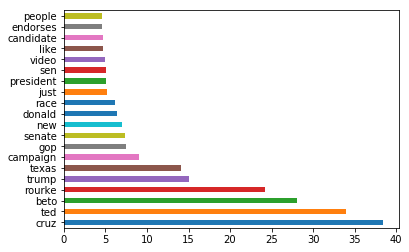

In [997]:
df_words_cv = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
df_words_tvec = pd.DataFrame(X_train.toarray(), columns=tvec.get_feature_names())

#Export top words for WordCloud in Tableau
df_words_cv.sum().sort_values(ascending=False).head(100).to_csv('top_words.csv', 
                                                                header=['Word Count'], 
                                                                index=True)
df_words_tvec.sum().sort_values(ascending=False).head(100).to_csv('tvec_top_words.csv', 
                                                                header=['Word Count'], 
                                                                index=True)
#make Graph
df_words_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh');


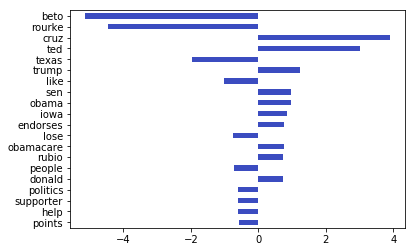

In [1196]:
### Analyze the coefs 

coefs = pd.DataFrame(lr.coef_,columns=tvec.get_feature_names()).T
coefs['ABS'] = coefs[0].abs()
coefs.sort_values(by=0, ascending=False).head(25).to_csv('cruz_coefficients.csv')
coefs.sort_values(by=0, ascending=True).head(25).to_csv('beto_coefficients.csv')
coefs.sort_values(by='ABS', ascending=True).tail(20)[0].plot(kind='barh', cmap='coolwarm');

In [1205]:
# Make a model with no candidates to see how it will affect accuracy
tvec_nc = TfidfVectorizer(stop_words=custom_list)
# Initial Logistic Regression Model
lr_2 = LogisticRegression(random_state=42)

#Vectorize to new 
X2_train = tvec_nc.fit_transform(train_corpus)
X2_test = tvec_nc.transform(test_corpus)

# Run grid serach
gs_lr2 = GridSearchCV(lr_2,
                  param_grid={'penalty':['l1', 'l2'], 'C' : np.logspace(0, 5, 10)})
best_model_lr2 = gs_lr2.fit(X2_train, y_train)

In [1206]:
lr2_best = LogisticRegression(penalty=best_model_lr2.best_estimator_.get_params()['penalty'],
                             C=best_model_lr2.best_estimator_.get_params()['C'],
                             random_state=42)
lr2_best.fit(X2_train, y_train);
lr2_best_predict = lr2_best.predict(X2_test)
make_pretty_conmat(y_test, lr2_best_predict)

accuracy score: 0.9095744680851063


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,78,16
TedCruz,1,93


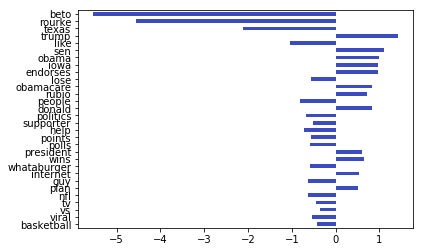

In [1208]:
### Analyze the coefs 

coefs_2 = pd.DataFrame(lr2_best.coef_,columns=tvec_nc.get_feature_names()).T
coefs_2['ABS'] = coefs[0].abs()
coefs_2.sort_values(by='ABS', ascending=True).tail(30)[0].plot(kind='barh', cmap='coolwarm');


## Predicting subreddit using Random Forests + Another Classifier

In [ ]:
## YOUR CODE HERE

#### We want to predict a binary variable - class `0` for one of your subreddits and `1` for the other.

In [65]:
df['beto'] = [1 if df.loc[i,'subreddit'] == 'Beto_for_Senate' else 0 for i in range(df.shape[0])]

#### Thought experiment: What is the baseline accuracy for this model?

The baseline accuracy is the higher percentage of the split between each subreddit. If you were to just guess randomly, then these splits are what you would expect to achieve.

In [999]:
df['subreddit'].value_counts(normalize=True)

Beto_for_Senate    0.50133
TedCruz            0.49867
Name: subreddit, dtype: float64

#### Create a `RandomForestClassifier` model to predict which subreddit a given post belongs to.

In [1000]:
## YOUR CODE HERE
rf = RandomForestClassifier(random_state=42)


In [1001]:
rf.fit(X_train, y_train);
predictions_rf = rf.predict(X_test)

In [1002]:
make_pretty_conmat(y_test, predictions_rf)

accuracy score: 0.8936170212765957


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,81,13
TedCruz,7,87


##### GridSearch

In [1003]:
gs_rf = GridSearchCV(rf,
                  param_grid={'n_estimators':[15,20,25,30,35],
                              'criterion': ['gini', 'entropy']})
best_model_rf = gs_rf.fit(X_train, y_train)
results_rf = gs_rf.cv_results_

In [1004]:
print('Best # of Trees:', best_model_rf.best_estimator_.get_params()['n_estimators'])
print('Best Criterion:', best_model_rf.best_estimator_.get_params()['criterion'])

Best # of Trees: 30
Best Criterion: entropy


In [1005]:
rf_best = RandomForestClassifier(n_estimators=25, random_state=42)

In [1006]:
rf_best.fit(X_train, y_train);
rf_best_predict = rf_best.predict(X_test)
make_pretty_conmat(y_test, rf_best_predict)

accuracy score: 0.9308510638297872


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,85,9
TedCruz,4,90


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 
- **Bonus**: Use `GridSearchCV` with `Pipeline` to optimize your `CountVectorizer`/`TfidfVectorizer` and classification model.

In [ ]:
## YOUR CODE HERE

In [616]:
df_cv_scores = pd.DataFrame()
cross_val_score(lr_best, X_train, y_train).mean()


0.7393862433862433

In [476]:
df_scores = pd.DataFrame()
df_scores['Run Type'] = 'Default'
df_scores['Log'] = lr.score(X_test, y_test)
df_scores['Random Forest'] = rf.score(X_test, y_test)
df_scores['Gradient Boost'] = gb.score(X_test, y_test)
df_scores['Extra Trees'] = et.score(X_test, y_test)

In [477]:
df_scores

,Run Type,Log,Random Forest,Gradient Boost,Extra Trees


In [139]:
model = MultinomialNB()

#### Repeat the model-building process using a different classifier (e.g. `MultinomialNB`, `LogisticRegression`, etc)

### Gradient Boost Models

In [1007]:
## YOUR CODE HERE
gb = GradientBoostingClassifier(random_state=42)

In [1008]:
gb.fit(X_train, y_train);
predictions_gb = gb.predict(X_test)

In [1009]:
make_pretty_conmat(y_test, predictions_gb)

accuracy score: 0.9468085106382979


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,88,6
TedCruz,4,90


In [1010]:
print(classification_report(y_test, predictions_gb))

                 precision    recall  f1-score   support

Beto_for_Senate       0.96      0.94      0.95        94
        TedCruz       0.94      0.96      0.95        94

    avg / total       0.95      0.95      0.95       188



##### Grid Search

In [1014]:
gs_gb = GridSearchCV(gb,
                  param_grid={'n_estimators':[50,100,150],
                              'max_depth': [3,5,10]})
best_model_gb = gs_gb.fit(X_train, y_train)
results_gb = gs_gb.cv_results_
print('Best # of Estimators:', best_model_gb.best_estimator_.get_params()['n_estimators'])
print('Best Max Depth:', best_model_gb.best_estimator_.get_params()['max_depth'])

Best # of Estimators: 100
Best Max Depth: 3


In [1015]:
gb_best = GradientBoostingClassifier(n_estimators=200,max_depth=10, random_state=42)

In [1016]:
gb_best.fit(X_train, y_train);
gb_best_predict = gb_best.predict(X_test)
make_pretty_conmat(y_test, gb_best_predict)

accuracy score: 0.9468085106382979


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,88,6
TedCruz,4,90


### Extra Trees Models

In [1017]:
et = ExtraTreesClassifier(random_state=42)

In [1018]:

et.fit(X_train, y_train);
predictions_et = et.predict(X_test)

In [1019]:
make_pretty_conmat(y_test, predictions_et)

accuracy score: 0.9042553191489362


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,84,10
TedCruz,8,86


##### Grid Search

In [1020]:
gs_et = GridSearchCV(et,
                  param_grid={'n_estimators':[10,15,20,25],
                              'criterion': ['gini', 'entropy']})
best_model_et = gs_et.fit(X_train, y_train)
results_et = gs_et.cv_results_
print('Best # of Estimators:', best_model_et.best_estimator_.get_params()['n_estimators'])
print('Best Criterion:', best_model_et.best_estimator_.get_params()['criterion'])

Best # of Estimators: 20
Best Criterion: gini


In [1021]:
et_best = ExtraTreesClassifier(n_estimators =20, criterion='gini', random_state=42)

In [1022]:
et_best.fit(X_train, y_train);
et_best_predict = et_best.predict(X_test)
make_pretty_conmat(y_test, et_best_predict)

accuracy score: 0.9095744680851063


,Predicted: Beto_for_Senate,Predicted: TedCruz
Beto_for_Senate,82,12
TedCruz,5,89


### Pipeline of Models

In [1034]:
# Create a pipeline
pipe = Pipeline([('tvec', TfidfVectorizer(stop_words=word_list)),
                 #('cv', CountVectorizer()),
                 ('lr', LogisticRegression(random_state=42)),
                 #('gb', GradientBoostingClassifier(random_state=42))
                 #('mn', MultinomialNB())
                 
                ])

# Create space of candidate learning algorithms and their hyperparameters
search_space = {'tvec__ngram_range': [(1,1),(1,2), (1,3)],
                'tvec__max_features' : [None,100,500],
                'tvec__min_df' : [1,5,10],
                #'cv__ngram_range': [(1,1), (1,2), (1,3)],
                #'cv__min_df' : [1,3,5,7],
                #'cv__stop_words' : [candidate_list, custom_list]
                'lr__penalty':['l1', 'l2'],
                'lr__C' : np.logspace(0, 5, 10),
                #'gb__n_estimators':[100,125,150],
                #'gb__max_depth': [3,5,10]
                 }
               

In [1035]:
# Create grid search 
gs = GridSearchCV(pipe, param_grid=search_space)

In [1036]:
# Fit grid search
best_model = gs.fit(train_corpus, y_train)
best_model.best_score_

0.9450354609929078

In [1037]:
# View best model
best_model.best_estimator_.get_params()['tvec']

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['per', 'beside', 'as', 'more', 'next', 'anyway', 'once', 'few', 'under', 'due', 'first', 'is', 'the', 'yours', 'amount', 'these', 'were', 'fifty', 'myself', 'via', 'anyone', 'others', 'when', 'not', 'still', 'behind', 'an', 'ourselves', 'ltd', 'put', 'so', 'two', 'i', 'becomes', 'had', '...y', 'would', 'much', 'describe', 'whereby', 'anyhow', 'yet', 'herein', 'each', 'yourself', 'become'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [1038]:
best_model.best_estimator_.get_params()['lr']

LogisticRegression(C=3.5938136638046276, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Application

We will look to see if we can apply the trained data to other subreddits related to Texas and Politics to see if we can see if the discussion is more related to Beto or to Cruz.

#### Start with r/Texas

In [1065]:
reddit_scraper('texas', 39)

http://www.reddit.com/r/texas.json
http://www.reddit.com/r/texas.json?after=t3_9e9ye0
http://www.reddit.com/r/texas.json?after=t3_9dvxwp
http://www.reddit.com/r/texas.json?after=t3_9e15nn


/Users/macbookpro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



http://www.reddit.com/r/texas.json?after=t3_9dbeee
http://www.reddit.com/r/texas.json?after=t3_9d51qm
http://www.reddit.com/r/texas.json?after=t3_9d2ldi
http://www.reddit.com/r/texas.json?after=t3_9cpv8t
http://www.reddit.com/r/texas.json?after=t3_9conac
http://www.reddit.com/r/texas.json?after=t3_9c8tjj
http://www.reddit.com/r/texas.json?after=t3_9c5r71
http://www.reddit.com/r/texas.json?after=t3_9bz2aq
http://www.reddit.com/r/texas.json?after=t3_9bkjgc
http://www.reddit.com/r/texas.json?after=t3_9blrjm
http://www.reddit.com/r/texas.json?after=t3_9bj51g
http://www.reddit.com/r/texas.json?after=t3_9b1dpo
http://www.reddit.com/r/texas.json?after=t3_9av07n
http://www.reddit.com/r/texas.json?after=t3_9a6dau
http://www.reddit.com/r/texas.json?after=t3_9a0pz6
http://www.reddit.com/r/texas.json?after=t3_99otct
http://www.reddit.com/r/texas.json?after=t3_99f6zl
http://www.reddit.com/r/texas.json?after=t3_99ej1o
http://www.reddit.com/r/texas.json?after=t3_98x7sf
http://www.reddit.com/r/texas.j

(968, 96)

In [1066]:
# Import data
texas_data = pd.read_csv('texas.csv')
texas_df = pd.DataFrame(texas_data)

In [1239]:
# Filter data specific to referencing Beto or Cruz
texas_filter_df = texas_df.loc[texas_df['title'].str.contains('beto|cruz|ted cruz|rourke', case=False)]

In [1240]:
texaspolitics_df = texas_df.loc[texas_df['link_flair_text'] == 'Politics']

In [1241]:
texas_filter_df.shape

(115, 96)

In [1242]:
texaspolitics_df.shape

(43, 96)

#### Run Predictions on Texas subreddit filtered posts

In [1243]:
lr3 = best_model.best_estimator_.get_params()['lr']

In [1244]:
TX_test = texas_filter_df.loc[:,['selftext', 'title', 'subreddit']]
TX_test.fillna("", inplace=True)
TX_test['title_text'] = TX_test['title'] + " " + TX_test['selftext']


In [1249]:
X_texas = tvec.transform(TX_test['title_text'])
tx_predict = lr3.predict(X_texas)

In [1250]:
tx_predict_prob = lr3.predict_proba(X_texas)

In [1251]:
tx_predictions = pd.DataFrame({'prediction':tx_predict.tolist()})

In [1252]:
tx_predictions['P_Beto'] = tx_predict_prob[:,0]
tx_predictions['P_Cruz'] = tx_predict_prob[:,1]

In [1253]:
tx_predictions.head()

,prediction,P_Beto,P_Cruz
0,Beto_for_Senate,0.680453,0.319547
1,Beto_for_Senate,0.727805,0.272195
2,Beto_for_Senate,0.998703,0.001297
3,Beto_for_Senate,0.966358,0.033642
4,Beto_for_Senate,0.907903,0.092097


In [1254]:
simple = TX_test.iloc[:,[-1]]
simple.reset_index(drop=True, inplace=True)
tx_p = pd.concat([tx_predictions,simple], axis=1)

In [1255]:
tx_p['prediction'].value_counts(normalize=True)

Beto_for_Senate    0.686957
TedCruz            0.313043
Name: prediction, dtype: float64

In [1256]:
tx_p.sort_values('P_Beto', inplace=True)

In [1257]:
tx_p.to_csv("texas_analysis.csv")

In [1259]:
tx_p.head()

,prediction,P_Beto,P_Cruz,title_text
62,TedCruz,0.000415,0.999585,Ted Cruz: Servile Puppy
52,TedCruz,0.000415,0.999585,"Ted Cruz: Brainless, Heartless Spineless"
34,TedCruz,0.007553,0.992447,Ted Cruz: Donald Trump Is a 'Pathological Liar'
22,TedCruz,0.039838,0.960162,Ted Cruz: Americans Have No Right To Masturbate
111,TedCruz,0.046096,0.953904,Ted Cruz says it was President Obama who was ‘...


# Executive Summary
---



Campaigns have radically changed. As demonstrated in 2016, viral content and online message can have a powerful influence over the state of the race. Party platforms have less influence now than what is being discussed across the internet. The challenge for modern campaigns is to be able to effectively stay on top and get the message they want to reach voters.

With the midterm election fast approaching, it is essential for campaigns to know where they stand in the race. We know that there are many social media platforms out there and much of their content can be traced back to reddit. With the speed at which viral content spreads, it is vital to know if your message is working or if your opponent's attack ads are negatively affecting your campaign. 

That's why our model can help provide insight into the discussion. We can take a pulse on voters dialog about your campaign and map it to target areas of reddit. This can determine if your message is resonating with the right audience or if your opponent's message is still dominating.

With an accuracy of over 94%, our model can predict the strength of one candidates message across Reddit. Our model is flexible enough to give campaigns the tools to explore any number of subreddit and generate their own pulse on the race. And with the ability to expand and adapt key words, we can also tell how effective your message is reaching voters.

With so much at stake in this election, it is essential to stay ahead of the curve. If you want to stay one step ahead in the race, our model can provide the insight to know where you campaign stands. 

